2020-05-12 12:12:36 INFO: Read cfg files: /home/jovyan/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg, /home/jovyan/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg, /home/jovyan/.spynnaker.cfg
2020-05-12 12:12:36 INFO: Will search these locations for binaries: /home/jovyan/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/common_model_binaries : /home/jovyan/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/model_binaries
2020-05-12 12:12:36 WARNING: /home/jovyan/SpeechRecognition/reports has 17 old reports that have not been closed
2020-05-12 12:12:36 WARNING: /home/jovyan/SpeechRecognition/application_generated_data_files has 17 old reports that have not been closed
2020-05-12 12:12:36 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2020-05-12 12:12:36 INFO: Setting time sca

Detected PyNN version 0.9.4 and Neo version 0.6.1
['/home/jovyan/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg', '/home/jovyan/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg', '/home/jovyan/.spynnaker.cfg']


2020-05-12 12:12:40 INFO: Time 0:00:03.475062 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2020-05-12 12:12:49 INFO: Time 0:00:09.208839 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2020-05-12 12:12:55 INFO: Time 0:00:05.934901 taken by PartitionAndPlacePartitioner
Created spalloc job 5355120
2020-05-12 12:12:55 INFO: Created spalloc job 5355120
Waiting for board power commands to complete.
2020-05-12 12:12:55 INFO: Waiting for board power commands to complete.
2020-05-12 12:13:00 INFO: Time 0:00:05.050830 taken by SpallocAllocator
2020-05-12 12:13:00 INFO: Creating transceiver for 10.11.196.145
2020-05-12 12:13:00 INFO: Working out if machine is booted
2020-05-12 12:13:04 INFO: Attempting t

<IPython.core.display.Javascript object>


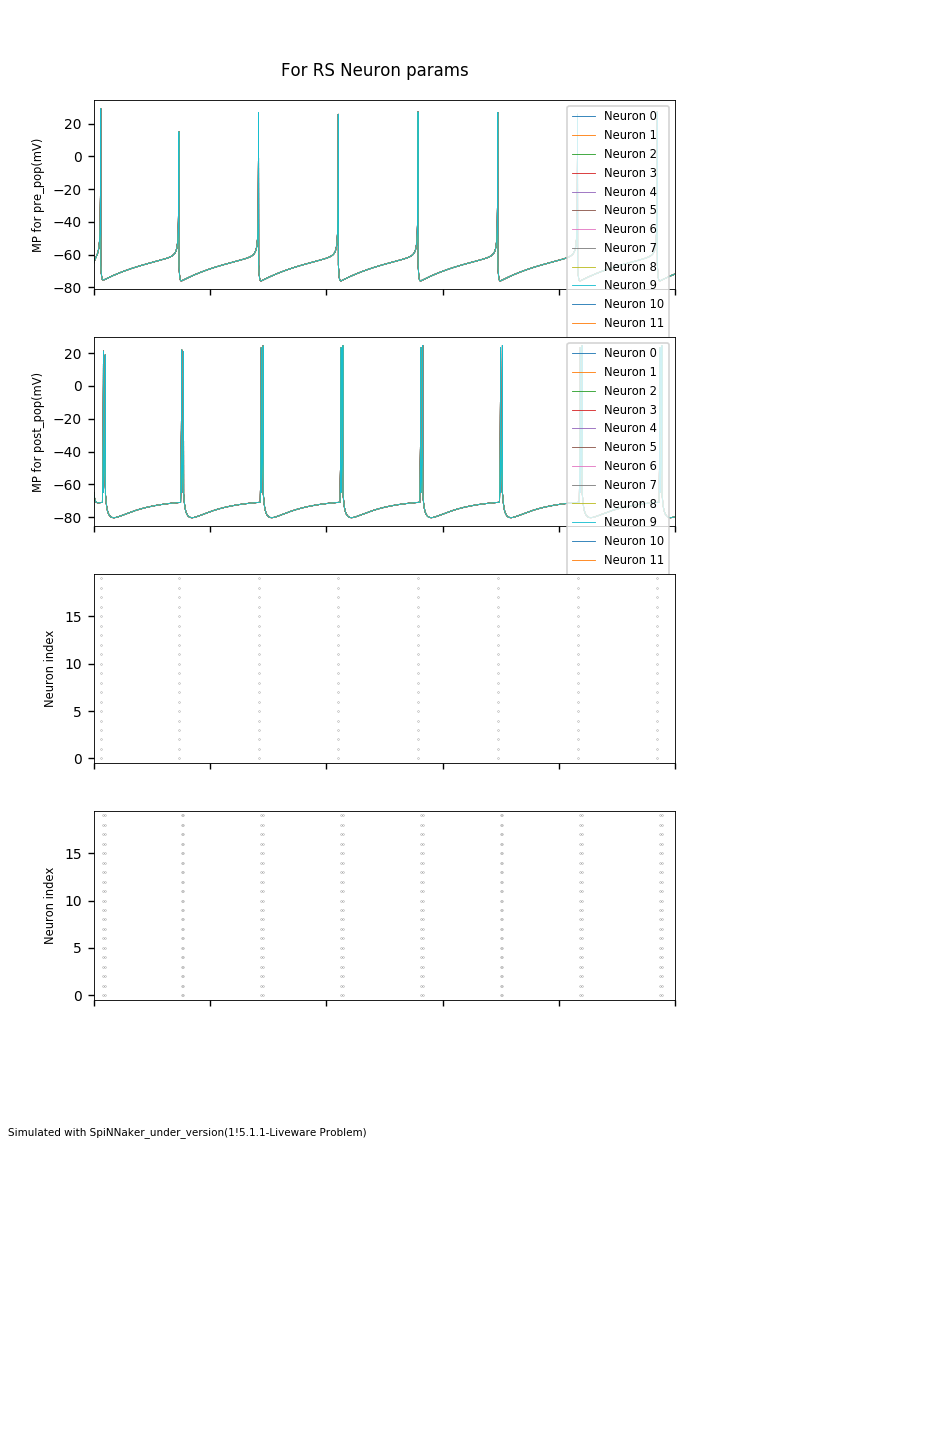

In [1]:
try:
    import pyNN.spiNNaker as sim
except Exception as e:
    import synnaker8 as sim
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import pyNN.utility.plotting as plot
import random

#spynnaker setup
sim.setup(timestep=0.1, min_delay=1.0)



model = sim.extra_models.Izhikevich_cond


snr_a=0.02 #0.005 #0.1
snr_b=0.2 #0.32
snr_c=-65 #-65
snr_d=8 #2
snr_v_init = -65 #-70
snr_u_init = snr_b * snr_v_init

tau_ampa = 6###excitatory synapse time constant
tau_gabaa= 4### inhibitory synapse time constant
E_ampa = 0.0
E_gabaa = -80.0
current_bias = 4.0
cell_params_input = {'a': snr_a, 'b': snr_b, 'c': snr_c, 'd': snr_d,
                   'v': snr_v_init, 'u': snr_u_init,
                   'tau_syn_E': tau_ampa, 'tau_syn_I': tau_gabaa,
                   'i_offset': current_bias,
                   'e_rev_E': E_ampa, 'e_rev_I': E_gabaa,
                   }

cell_params_output = {'a': snr_a, 'b': snr_b, 'c': snr_c, 'd': snr_d,
                   'v': snr_v_init, 'u': snr_u_init,
                   'tau_syn_E': tau_ampa, 'tau_syn_I': tau_gabaa,
                   'i_offset': 0.0,
                   'e_rev_E': E_ampa, 'e_rev_I': E_gabaa,
                   }

pop_size = 20

simtime = 1000

pre_pop = sim.Population(pop_size, model(**cell_params_input))
post_pop = sim.Population(pop_size, model(**cell_params_output))


wiring = sim.OneToOneConnector()
static_synapse = sim.StaticSynapse(weight=0.5, delay=3.0)
connections = sim.Projection(pre_pop, post_pop, wiring, static_synapse)

#record data
pre_pop.record(['v', 'spikes'])
post_pop.record(['v', 'spikes'])

#start simulation
sim.run(simtime)

# print("Weights:{}".format(plastic_projection.get('weight', 'list')))

#get data in neo format
neo_pre_spikes = pre_pop.get_data(variables = ['spikes','v'])
neo_post_spikes = post_pop.get_data(variables = ['spikes','v'])

#spiketrains
pre_pop_spikes = neo_pre_spikes.segments[0].spiketrains
post_pop_spikes = neo_post_spikes.segments[0].spiketrains

#membrane potential
pre_pop_v = neo_pre_spikes.segments[0].filter(name='v')[0]
post_pop_v = neo_post_spikes.segments[0].filter(name='v')[0]

#end simulation
sim.end()

# print("Weights:{}".format(connections.get('weight', 'list')))

# Plot
plot.Figure(
    # plot voltage(pre_pop) for first ([0]) neuron
    plot.Panel(pre_pop_v, ylabel="MP for pre_pop(mV)",
               yticks=True, markersize=0.2, xlim=(0, simtime)),
    # plot voltage(post_pop) for first ([0]) neuron
    plot.Panel(post_pop_v, ylabel="MP for post_pop(mV)",
              yticks=True, markersize=0.2, xlim=(0, simtime)),
    # plot spikes(pre_pop) (or in this case spike)
    plot.Panel(pre_pop_spikes, yticks=True, markersize=0.2, xlim=(0, simtime)),
    # plot spikes(post_pop) (or in this case spike)
    plot.Panel(post_pop_spikes, yticks=True, markersize=0.2, xlim=(0, simtime)),
    title="For RS Neuron params",
    annotations="Simulated with {}".format(sim.name())).save('Pre-Post-test-static-0.5-no-curr-to-outputlayer.png')
plt.show()
# Figure(Panel(pre_spikes.segments[0].spiketrains, yticks=True, markersize=0.2, xlim=(0,simtime)), Panel(post_spikes.segments[0].spiketrains, yticks=True, markersize=0.2, xlim=(0,simtime)), title="stdp example", annotations="simulated with {}".format(sim.name())).save('testSpiketrains.png')


In [2]:
len(post_pop_spikes[0])

16

In [3]:
spike_intervals = []
for i in range(1, len(post_pop_spikes[0])):
    spike_intervals.append(post_pop_spikes[0][i]-post_pop_spikes[0][i-1])
    print(post_pop_spikes[0][i]-post_pop_spikes[0][i-1])

3.200000000000003 ms
131.3 ms
3.1999999999999886 ms
133.9 ms
3.1999999999999886 ms
134.0 ms
3.2000000000000455 ms
134.0 ms
3.199999999999932 ms
134.0000000000001 ms
3.199999999999932 ms
134.0 ms
3.2000000000000455 ms
134.0 ms
3.199999999999932 ms


In [4]:
spike_interval_threshold = 3.5 #set by taking a look at the intervals

In [9]:
spike_intervals_inter = []
spike_intervals_intra = []
for interval in spike_intervals:
    if interval>spike_interval_threshold:
        spike_intervals_inter.append(interval)
    else:
        spike_intervals_intra.append(interval)

avg_inter_burst_interval = 0
for i in spike_intervals_inter:
    avg_inter_burst_interval += i.magnitude
avg_inter_burst_interval /= len(spike_intervals_inter)
print("average inter burst interval in ms:-", avg_inter_burst_interval)
                                
avg_intra_burst_interval = 0
for i in spike_intervals_intra:
    avg_intra_burst_interval += i.magnitude
avg_intra_burst_interval /= len(spike_intervals_intra)
print("average intra burst interval in ms :-", avg_intra_burst_interval)

average inter burst interval in ms:- 133.60000000000002
average intra burst interval in ms :- 3.1999999999999833


In [10]:
print("average intra burst frequency:-", 1000/avg_intra_burst_interval) #multiply by 1000 because time is in ms

average intra burst frequency:- 312.50000000000165
